<a href="https://colab.research.google.com/github/zxzhaixiang/GANstudy/blob/master/CityScape_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### set up google drive folder

In [0]:
#Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
testA  testB  trainA  trainB


In [3]:
#download dataset
import os
import zipfile
if (not os.path.exists('./cityscapes.zip')):
  !wget "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/cityscapes.zip"
if (not os.path.isdir('./cityscapes')):
  zip_ref = zipfile.ZipFile('cityscapes.zip','r')
  zip_ref.extractall('cityscapes')
  zip_ref.close()

--2018-11-23 04:00:43--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/cityscapes.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279601602 (267M) [application/zip]
Saving to: ‘cityscapes.zip’

cityscapes.zip      100%[===================>] 266.65M  20.7MB/s    in 14s     

2018-11-23 04:00:57 (19.7 MB/s) - ‘cityscapes.zip’ saved [279601602/279601602]



### Prepare libraries

In [4]:
!pip uninstall Pillow
!pip install Pillow==4.1.1
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install torchsummary


Uninstalling Pillow-4.0.0:
  Would remove:
    /usr/local/bin/createfontdatachunk.py
    /usr/local/bin/enhancer.py
    /usr/local/bin/explode.py
    /usr/local/bin/gifmaker.py
    /usr/local/bin/painter.py
    /usr/local/bin/pilconvert.py
    /usr/local/bin/pildriver.py
    /usr/local/bin/pilfile.py
    /usr/local/bin/pilfont.py
    /usr/local/bin/pilprint.py
    /usr/local/bin/player.py
    /usr/local/bin/thresholder.py
    /usr/local/bin/viewer.py
    /usr/local/lib/python3.6/dist-packages/PIL/*
    /usr/local/lib/python3.6/dist-packages/Pillow-4.0.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.7MB 7.3MB/s 
    100% |████████████████████████████████| 512.6MB 55.8MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58614000 @  0x7f82dbf332a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import transforms
import time
import sys
import random
from skimage import io
from torchsummary import summary as PyTorchSummary
from collections import namedtuple
from PIL import ImageEnhance

%matplotlib inline

In [6]:
print('# of files under trainA %d' % len(os.listdir('./cityscapes/cityscapes/trainA')))
print('# of files under trainB %d' % len(os.listdir('./cityscapes/cityscapes/trainB')))


# of files under trainA 2975
# of files under trainB 2975


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Seed = 123
batch_size = 32

print('Device is ', device)

Device is  cuda


### prepare data loader

In [0]:
class LoadCityScapeDataset(Dataset):
    '''
    prepare dataset for data loader

    INPUT
    dataset_name: name of the dataset
    dataset_type: 'train' or 'test'
    n: number of output

    OUTPUT
    conventional dataset along with .stats attribute which contains useful summary stats used in computing rsquared
    '''
    def __init__(self, dataset_name, dataset_type='train', seed = 123, transform = None,  N = -1):       
        self.rootpath = './cityscapes/'
        self.A_path = os.path.join(self.rootpath,dataset_name,dataset_type+'A/')
        self.B_path = os.path.join(self.rootpath,dataset_name,dataset_type+'B/')
        
        self.A_file_list = os.listdir(self.A_path)
        self.B_file_list = os.listdir(self.B_path)
        self.A_file_list.sort()
        self.B_file_list.sort()
        self.label_colors, self.label_list = self.Labels()
        self.nC = self.label_colors.shape[0]
        n = len(self.A_file_list)
        
        if (N!=-1 and N<=n):
            ind_new_list = random.sample(range(n),N)
            self.A_file_list = [self.A_file_list[i] for i in ind_new_list]
            self.B_file_list = [self.B_file_list[i] for i in ind_new_list]

        self.transform = transform

    def loadImg(self,imgpath):
        image = io.imread(imgpath)
        if self.transform:
            image = self.transform(image)
        return image
    
    def loadLabelImg(self,imgpath):
        label_image_raw = io.imread(imgpath)
        #labels = np.argmin(np.array([np.square(label_image_raw-c).sum(axis=2) for c in self.label_colors]),axis=0)
        #labeled_image = (np.arange(self.nC) == labels[...,None]).astype(float)
        #image = torch.tensor(labeled_image.transpose((2,0,1)))        
        #return image, torch.tensor(labels), label_image_raw
        if self.transform:
            image = self.transform(label_image_raw)
        return image
        
    def __getitem__(self, index):
        imgA = self.loadImg(os.path.join(self.A_path, self.A_file_list[index]))
        imgB = self.loadLabelImg(os.path.join(self.B_path, self.B_file_list[index]))
        return imgA, imgB
        
    def __len__(self):
        return len(self.A_file_list)
      
    def Labels(self):
      

        Label = namedtuple( 'Label' , [

            'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                            # We use them to uniquely name a class

            'id'          , # An integer ID that is associated with this label.
                            # The IDs are used to represent the label in ground truth images
                            # An ID of -1 means that this label does not have an ID and thus
                            # is ignored when creating ground truth images (e.g. license plate).
                            # Do not modify these IDs, since exactly these IDs are expected by the
                            # evaluation server.

            'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                            # ground truth images with train IDs, using the tools provided in the
                            # 'preparation' folder. However, make sure to validate or submit results
                            # to our evaluation server using the regular IDs above!
                            # For trainIds, multiple labels might have the same ID. Then, these labels
                            # are mapped to the same class in the ground truth images. For the inverse
                            # mapping, we use the label that is defined first in the list below.
                            # For example, mapping all void-type classes to the same ID in training,
                            # might make sense for some approaches.
                            # Max value is 255!

            'category'    , # The name of the category that this label belongs to

            'categoryId'  , # The ID of this category. Used to create ground truth images
                            # on category level.

            'hasInstances', # Whether this label distinguishes between single instances or not

            'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                            # during evaluations or not

            'color'       , # The color of this label
            ] )

        labels = [
              #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
              Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
              Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
              Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
              Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
              Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
              Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
              Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
              Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
              Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
              Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
              Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
              Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
              Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
              Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
              Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
              Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
              Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
              Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
              Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
              Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
              Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
              Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
              Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
              Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
              Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
              Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
              Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
              Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
              Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
              Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
              Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
              Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
              Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
              Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
              Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
          ]
        label_colors = np.array([list(l.color) for l in labels])
        label_list = [l.name for l in labels]
        return label_colors, label_list


In [0]:
Train_data = LoadCityScapeDataset('cityscapes',dataset_type='train',
                transform = transforms.Compose([
                             #transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             ]))
Test_data = LoadCityScapeDataset('cityscapes',dataset_type='test',
                transform = transforms.Compose([
                             #transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             ]))

In [0]:
Train_loader = DataLoader(dataset=Train_data,
                          batch_size=batch_size, 
                          shuffle=False)
Test_loader = DataLoader(dataset=Test_data,
                          batch_size=batch_size, 
                          shuffle=False)

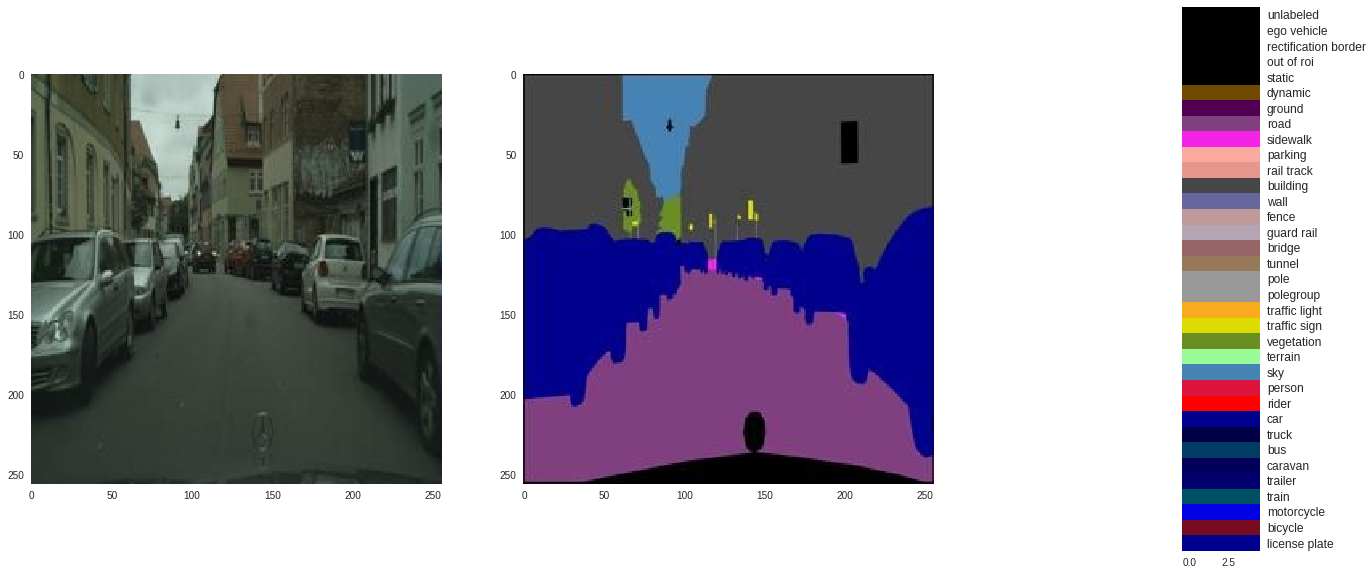

In [11]:
A, B = Train_data.__getitem__(100)
from matplotlib.colors import LinearSegmentedColormap
colors = Train_data.label_colors/255.0
label_list = Train_data.label_list
cm = LinearSegmentedColormap.from_list(
        'cityscapes', colors, N=colors.shape[0])

fig = plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(A.numpy().transpose((1,2,0)))
plt.grid('off')
plt.subplot(132)
plt.imshow(B.numpy().transpose((1,2,0)))
plt.grid('off')
#plt.subplot(143)
#plt.imshow(B_label[0].numpy(),cmap = cm, vmin = 0, vmax = len(label_list))
#plt.grid('off')
plt.subplot(133)
plt.imshow(np.repeat(np.array(range(colors.shape[0])).reshape((-1,1)),5,axis=1),cmap = cm)
plt.grid('off')
plt.yticks(range(colors.shape[0]), label_list, fontsize=12)
ax = plt.gca()
ax.yaxis.tick_right()
plt.show()


### Set up models

#### Encoder Generator

In [0]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.L1 = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2), # 3x256x256 -> 16x127x127
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(16, 32, 4, stride=2), # 16x127x127 -> 32x62x62
            nn.LeakyReLU(0.2,True)
        ) #3x256x256->32x62x62
        self.L2 = nn.Sequential(
            nn.Conv2d(32, 64, 4, stride=2), # 64x62x62 -> 128x30x30
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True)
        ) #32x62x62->64x30x30
        self.L3 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2), # 128x30x30 -> 256x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True)
        ) #64x30x30->128x14x14
        self.L4 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2), # 256x14x14 -> 512x6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True)
        ) #128x14x14->256x6x6
        self.L5 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2), # 512x6x6 -> 512x2x2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        ) #256x6x6->512x2x2
        
        self.DL1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2), #256x6x6
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        ) #512x2x2->256x6x6
        
        self.DL2 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, stride=2), #128x14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        ) #(256+256)x6x6->128x14x14
        
        self.DL3 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, stride=2), #64x30x30
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        ) #(128+128)x14x14->64x30x30
        
        self.DL4 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 4, stride=2), #32x62x62
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        ) #(64+64)x30x30->32x62x62
        self.DL5 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 4, stride=2), #16x126x126
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 4, stride=2), #16x254x254
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 7, stride=1), #16x260x260
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=1), #8x258x258
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 3, 3, stride=1), #3x256x256
            nn.Sigmoid()
        ) #(32+32)x62x62->3x256x256

    def attach(self,x1,x2):
      return torch.cat((x1,x2), 1)
    
    def forward(self, x):
        L1_out  = self.L1(x)
        L2_out  = self.L2(L1_out)
        L3_out  = self.L3(L2_out)
        L4_out  = self.L4(L3_out)
        L5_out  = self.L5(L4_out)
        DL1_out = self.DL1(L5_out)
        DL2_out = self.DL2(self.attach(DL1_out, L4_out))
        DL3_out = self.DL3(self.attach(DL2_out, L3_out))
        DL4_out = self.DL4(self.attach(DL3_out, L2_out))
        DL5_out = self.DL5(self.attach(DL4_out, L1_out))
        return DL5_out

In [0]:
class autoencoder2(nn.Module):
    def __init__(self):
        super(autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2), # 3x256x256 -> 16x127x127
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(16, 32, 4, stride=2), # 16x127x127 -> 32x62x62
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(32, 64, 4, stride=2), # 64x62x62 -> 128x30x30
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64, 128, 4, stride=2), # 128x30x30 -> 256x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128, 256, 4, stride=2), # 256x14x14 -> 512x6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(256, 512, 4, stride=2), # 512x6x6 -> 512x2x2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2), #256x6x6
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2), #128x14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2), #64x30x30
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2), #32x62x62
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, stride=2), #16x126x126
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 4, stride=2), #16x254x254
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 7, stride=1), #16x260x260
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=1), #8x258x258
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 3, 3, stride=1), #3x256x256
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
class autoencoder1(nn.Module):
    def __init__(self):
        super(autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2), # 3x256x256 -> 16x126x126
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,True),
            nn.MaxPool2d(2, stride=2), # 16, 63, 63
            nn.Conv2d(16, 32, 5, stride=2), # 32, 30, 30
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,True),
            nn.MaxPool2d(2, stride=2), # 32, 15, 15
            nn.Conv2d(32, 64, 5, stride=2),  # 64, 6, 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.MaxPool2d(2, stride=2), # 64, 3, 3
            nn.Conv2d(64, 256, 3, stride=1),  # 256x1x1
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=1),#64x3x3
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 64x6x6
            nn.ConvTranspose2d(64, 32, 5, stride=2),  # 32x15x15
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 32x30x30
            nn.ConvTranspose2d(32, 16, 5, stride=2), # 32x63x63
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 32x126x126
            nn.ConvTranspose2d(16, 3, 6, stride=2), # 3x256x256,
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
G = Unet().to(device)

In [26]:
PyTorchSummary(G, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 127, 127]             784
         LeakyReLU-2         [-1, 16, 127, 127]               0
            Conv2d-3           [-1, 32, 62, 62]           8,224
         LeakyReLU-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 64, 30, 30]          32,832
       BatchNorm2d-6           [-1, 64, 30, 30]             128
         LeakyReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8          [-1, 128, 14, 14]         131,200
       BatchNorm2d-9          [-1, 128, 14, 14]             256
        LeakyReLU-10          [-1, 128, 14, 14]               0
           Conv2d-11            [-1, 256, 6, 6]         524,544
      BatchNorm2d-12            [-1, 256, 6, 6]             512
        LeakyReLU-13            [-1, 256, 6, 6]               0
           Conv2d-14            [-1, 51

#### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnnlayers = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2), # 3x256x256 -> 16x126x126
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), # 16, 63, 63
            nn.Conv2d(16, 32, 5, stride=2), # 32, 30, 30
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), # 32, 15, 15
            nn.Conv2d(32, 64, 5, stride=2),  # 64, 6, 6
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), # 64, 3, 3
            nn.Conv2d(64, 256, 3, stride=1),  # 256x1x1
            nn.BatchNorm2d(256),
            nn.ReLU(True)   
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid())
    def forward(self,x):
        out = self.cnnlayers(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super(PatchDiscriminator, self).__init__()
        self.cnnlayers = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2), # 3x256x256 -> 16x126x126
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1,True),
            nn.Conv2d(16, 32, 4, stride=2), # 32, 30, 30
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1,True),
            nn.Conv2d(32, 64, 3, stride=2),  # 64, 6, 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,True),
            nn.Conv2d(64, 64, 3, stride=2),  # 256x1x1
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,True),
            nn.MaxPool2d(2, stride=2), # 64, 3, 3
            nn.Conv2d(64, 256, 3, stride=1),  # 256x1x1
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1,True),
            nn.Conv2d(256, 1, 1, stride=1),  # 256x1x1
            nn.Sigmoid(),  # 256x1x1
            nn.MaxPool2d(5,stride=5)
        )
        self.fc = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid())
    def forward(self,x):
        out = self.cnnlayers(x)
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        return out

In [0]:
D = PatchDiscriminator().to(device)

In [29]:
PyTorchSummary(D, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 127, 127]             784
       BatchNorm2d-2         [-1, 16, 127, 127]              32
         LeakyReLU-3         [-1, 16, 127, 127]               0
            Conv2d-4           [-1, 32, 62, 62]           8,224
       BatchNorm2d-5           [-1, 32, 62, 62]              64
         LeakyReLU-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 30, 30]          18,496
       BatchNorm2d-8           [-1, 64, 30, 30]             128
         LeakyReLU-9           [-1, 64, 30, 30]               0
           Conv2d-10           [-1, 64, 14, 14]          36,928
      BatchNorm2d-11           [-1, 64, 14, 14]             128
        LeakyReLU-12           [-1, 64, 14, 14]               0
        MaxPool2d-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 25

In [0]:
G_criterion = nn.L1Loss()
D_criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

### Training

In [0]:
num_epochs = 200

train_glosses = []
train_dreallosses = []
train_dfakelosses = []
train_gdlosses = []
train_hlosses = []
train_drealAcc = []
train_dfakeAcc = []

test_losses = []
test_drealAcc = []
test_dfakeAcc = []

train_len = Train_data.__len__()
test_len = Test_data.__len__()

In [0]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

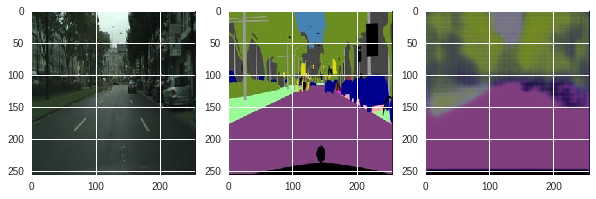

epoch[1/200], G:4.39e-03, D(real):2.91e-02, D(fake):1.39e-02, D(G):3.21e-02, hybrid:4.706e-03, ACC:D(real):0.000, D(fake):1.000

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

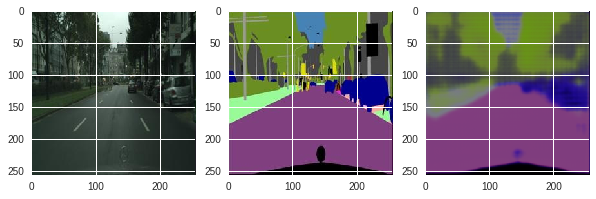

epoch[2/200], G:2.89e-03, D(real):2.68e-02, D(fake):1.22e-02, D(G):3.53e-02, hybrid:3.239e-03, ACC:D(real):0.000, D(fake):1.000

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

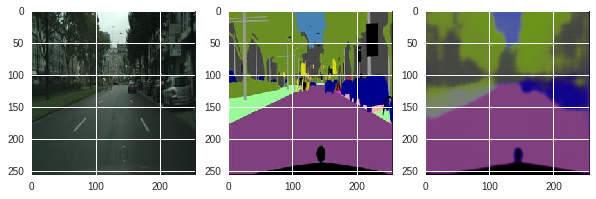

epoch[3/200], G:2.66e-03, D(real):2.48e-02, D(fake):1.20e-02, D(G):3.57e-02, hybrid:3.020e-03, ACC:D(real):0.000, D(fake):1.000

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

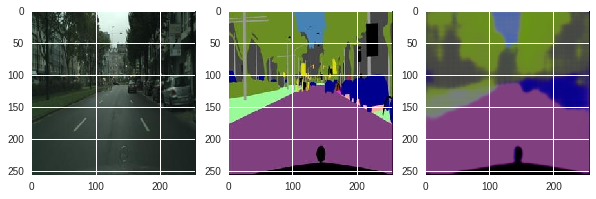

epoch[4/200], G:2.53e-03, D(real):2.34e-02, D(fake):1.18e-02, D(G):3.61e-02, hybrid:2.890e-03, ACC:D(real):0.000, D(fake):1.000

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

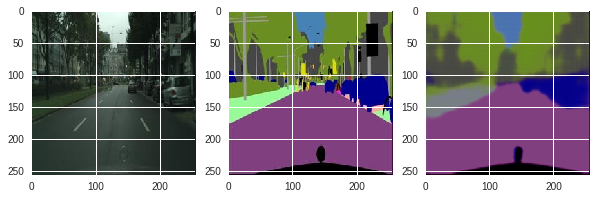

epoch[5/200], G:2.46e-03, D(real):2.24e-02, D(fake):1.16e-02, D(G):3.66e-02, hybrid:2.823e-03, ACC:D(real):0.001, D(fake):1.000

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

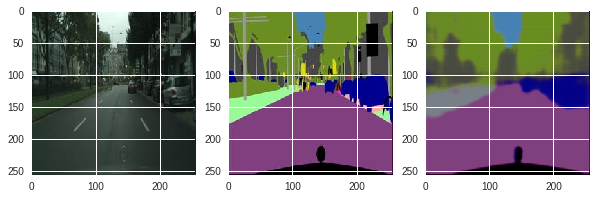

epoch[6/200], G:2.40e-03, D(real):2.16e-02, D(fake):1.15e-02, D(G):3.68e-02, hybrid:2.771e-03, ACC:D(real):0.658, D(fake):1.000

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,71 ,72 ,73 ,74 ,75 ,76 ,77 ,78 ,79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,87 ,88 ,89 ,90 ,91 ,92 ,

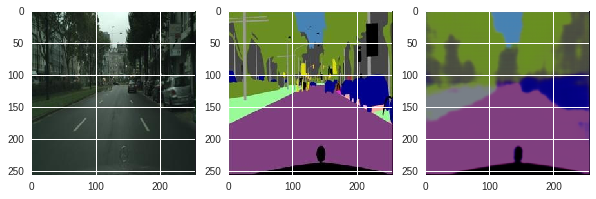

epoch[7/200], G:2.34e-03, D(real):2.10e-02, D(fake):1.14e-02, D(G):3.70e-02, hybrid:2.711e-03, ACC:D(real):0.983, D(fake):1.000

0 ,1 ,

KeyboardInterrupt: ignored

In [33]:
for epoch in range(num_epochs):
    train_gloss, train_dloss_real, train_dloss_fake, train_gdloss, train_hloss, test_loss = 0,0,0,0,0,0
    train_d_real_correct, train_d_fake_correct, test_d_real_correct, test_d_fake_correct = 0,0,0,0
    print()
    for i, (x,y) in enumerate(Train_loader):
        print(i,",",end="")
        x, y = x.to(device), y.to(device)
        yhat = G(x)

        g_loss = G_criterion(yhat, y)
        
        d_real = D(y)
        d_fake = D(yhat)
        tmp_batch_size = x.shape[0]
        real_labels = torch.ones((tmp_batch_size,1)).to(device)
        fake_labels = torch.zeros((tmp_batch_size,1)).to(device)
        
        d_loss_real = D_criterion(d_real, real_labels)
        d_loss_fake = D_criterion(d_fake, fake_labels)
        
        d_loss = 0.1*d_loss_real + 0.1*d_loss_fake
        reset_grad()
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        
        gd_loss = D_criterion(d_fake, real_labels)
        hybrid_loss = g_loss + 0.01*gd_loss
        reset_grad()
        hybrid_loss.backward()
        g_optimizer.step()
        
        train_d_real_correct+= (d_real>0.5).sum().item()
        train_d_fake_correct += (d_fake<0.5).sum().item()
        train_gloss += g_loss.item()
        train_dloss_real += d_loss_real.item()
        train_dloss_fake += d_loss_fake.item()
        train_gdloss += gd_loss.item()
        train_hloss += hybrid_loss.item()
        
    if(epoch%1==0):    
        plt.figure(figsize=(10,6))
        plt.subplot(131)
        plt.imshow(x[0].detach().cpu().numpy().transpose([1,2,0]))
        plt.subplot(132)
        plt.imshow(y[0].detach().cpu().numpy().transpose([1,2,0]),cmap = cm, vmin = 0, vmax = 35)
        plt.subplot(133)
        plt.imshow(yhat[0].detach().cpu().numpy().transpose([1,2,0]),cmap = cm, vmin = 0, vmax = 35)
        plt.show()
    
#     for i, (x,y) in enumerate(Test_loader):
#         x, y = x.to(device), y.to(device)
#         yhat = G(x)
#         loss = G_criterion(yhat,y)
#         test_loss+=loss.data[0]
#         d_real = D(y)
#         d_fake = D(yhat)
#         test_d_real_correct += (d_real>0.5).sum().item()
#         test_d_fake_correct += (d_fake<0.5).sum().item()

#     if(epoch%1==0):    
#         plt.subplot(143)
#         plt.imshow(y[8][0].detach().numpy(),cmap='jet', vmin = 0, vmax =1)
#         plt.title('true')
#         plt.subplot(144)
#         plt.imshow(yhat[8][0].detach().numpy(),cmap='jet', vmin = 0, vmax =1)
#         plt.title('test')
    
    train_d_real_correct /= train_len
    train_d_fake_correct /= train_len
    train_gloss          /= train_len
    train_dloss_real     /= train_len
    train_dloss_fake     /= train_len
    train_gdloss         /= train_len
    train_hloss          /= train_len
#     test_loss/=test_loader.dataset.len
#     test_d_real_correct/=test_loader.dataset.len
#     test_d_fake_correct/=test_loader.dataset.len
    
    train_glosses.append(train_gloss)
    train_dreallosses.append(train_dloss_real)
    train_dfakelosses.append(train_dloss_fake)
    train_gdlosses.append(train_gdloss)
    train_hlosses.append(train_hloss)
    train_drealAcc.append(train_d_real_correct)
    train_dfakeAcc.append(train_d_fake_correct)
#     test_losses.append(test_loss)
#     test_drealAcc.append(test_d_real_correct)
#     test_dfakeAcc.append(test_d_fake_correct)


    print('epoch[{}/{}], G:{:.2e}, D(real):{:.2e}, D(fake):{:.2e}, D(G):{:.2e}, hybrid:{:.3e}, ACC:D(real):{:.3f}, D(fake):{:.3f}'.
          format(epoch+1, num_epochs, train_gloss, train_dloss_real, train_dloss_fake, train_gdloss, train_hloss,
                train_d_real_correct, train_d_fake_correct))

Text(0.5,0,'epoch')

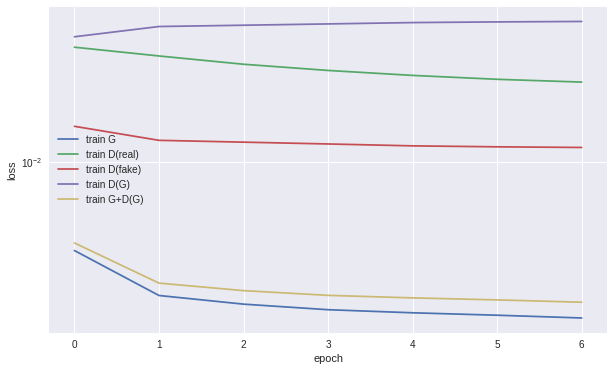

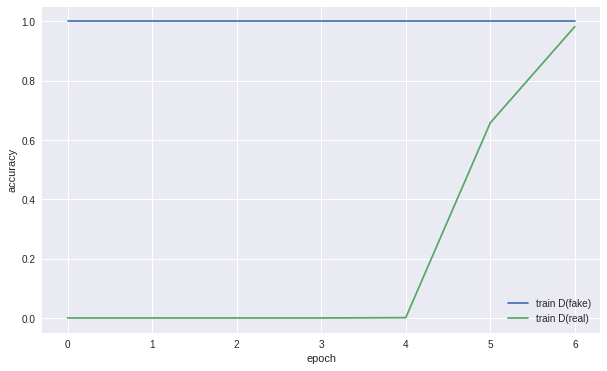

In [34]:
plt.figure(figsize=(10,6))
plt.plot(train_glosses, label='train G')
plt.plot(train_dreallosses, label='train D(real)')
plt.plot(train_dfakelosses, label='train D(fake)')
plt.plot(train_gdlosses, label='train D(G)')
plt.plot(train_hlosses, label='train G+D(G)')
#plt.plot(test_losses, label='test G')
plt.yscale('log')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

    
plt.figure(figsize=(10,6))
plt.plot(train_dfakeAcc, label='train D(fake)')
plt.plot(train_drealAcc, label='train D(real)')
#plt.plot(test_dfakeAcc, label='test D(fake)')
#plt.plot(test_drealAcc, label='test D(real)')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [0]:
for i, (x,y) in enumerate(Train_loader):
    xtrain, ytrain = x.to(device), y.to(device)
    ytrainhat = G(xtrain)
    xtrain = xtrain.detach().cpu().numpy().transpose((0,2,3,1))
    ytrain = ytrain.detach().cpu().numpy().transpose((0,2,3,1))
    ytrainhat = ytrainhat.detach().cpu().numpy().transpose((0,2,3,1))
    break

for i, (x,y) in enumerate(Test_loader):
    xtest, ytest = x.to(device), y.to(device)
    ytesthat = G(xtest)
    xtest = xtest.detach().cpu().numpy().transpose((0,2,3,1))
    ytest = ytest.detach().cpu().numpy().transpose((0,2,3,1))
    ytesthat = ytesthat.detach().cpu().numpy().transpose((0,2,3,1))
    break


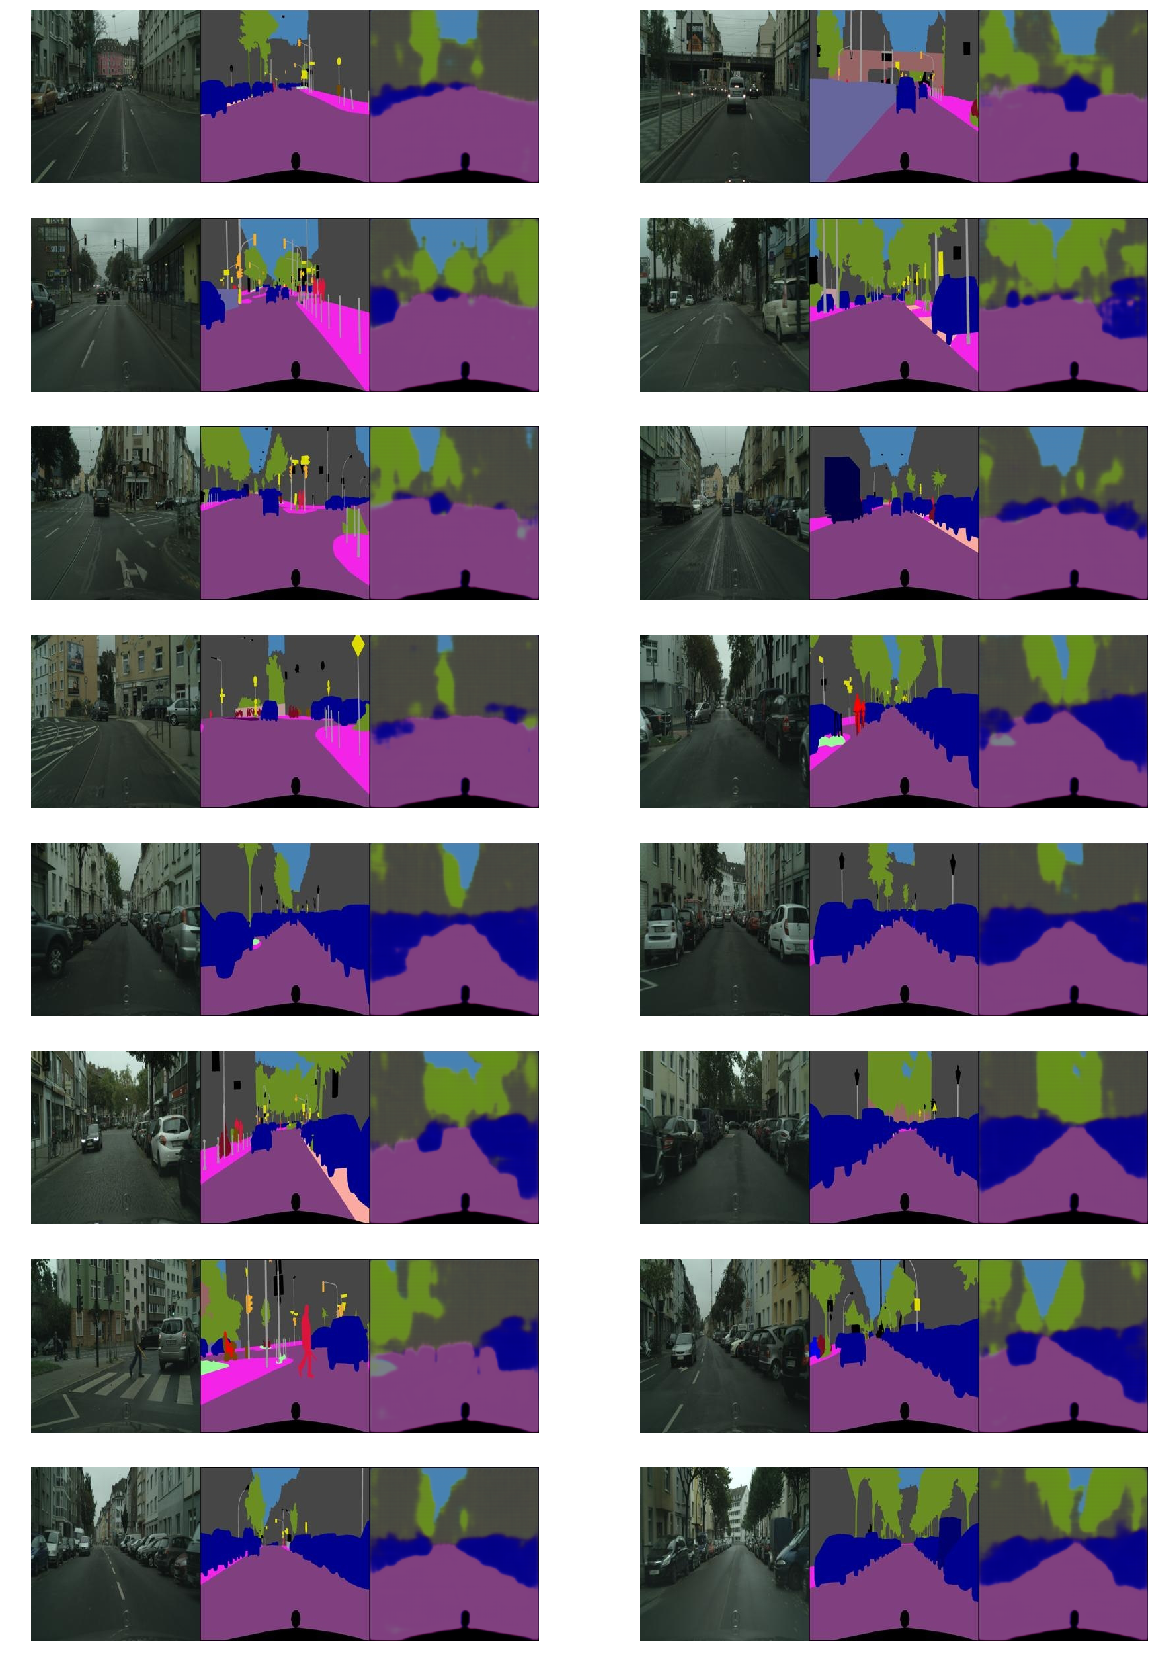

In [36]:
plt.figure(figsize=(20,30))
for i in range(16):
    plt.subplot(8,2,i+1)
    plt.imshow(np.concatenate((xtrain[i], ytrain[i], ytrainhat[i]),axis=1))
    plt.axis('tight')
    plt.axis('off')
    

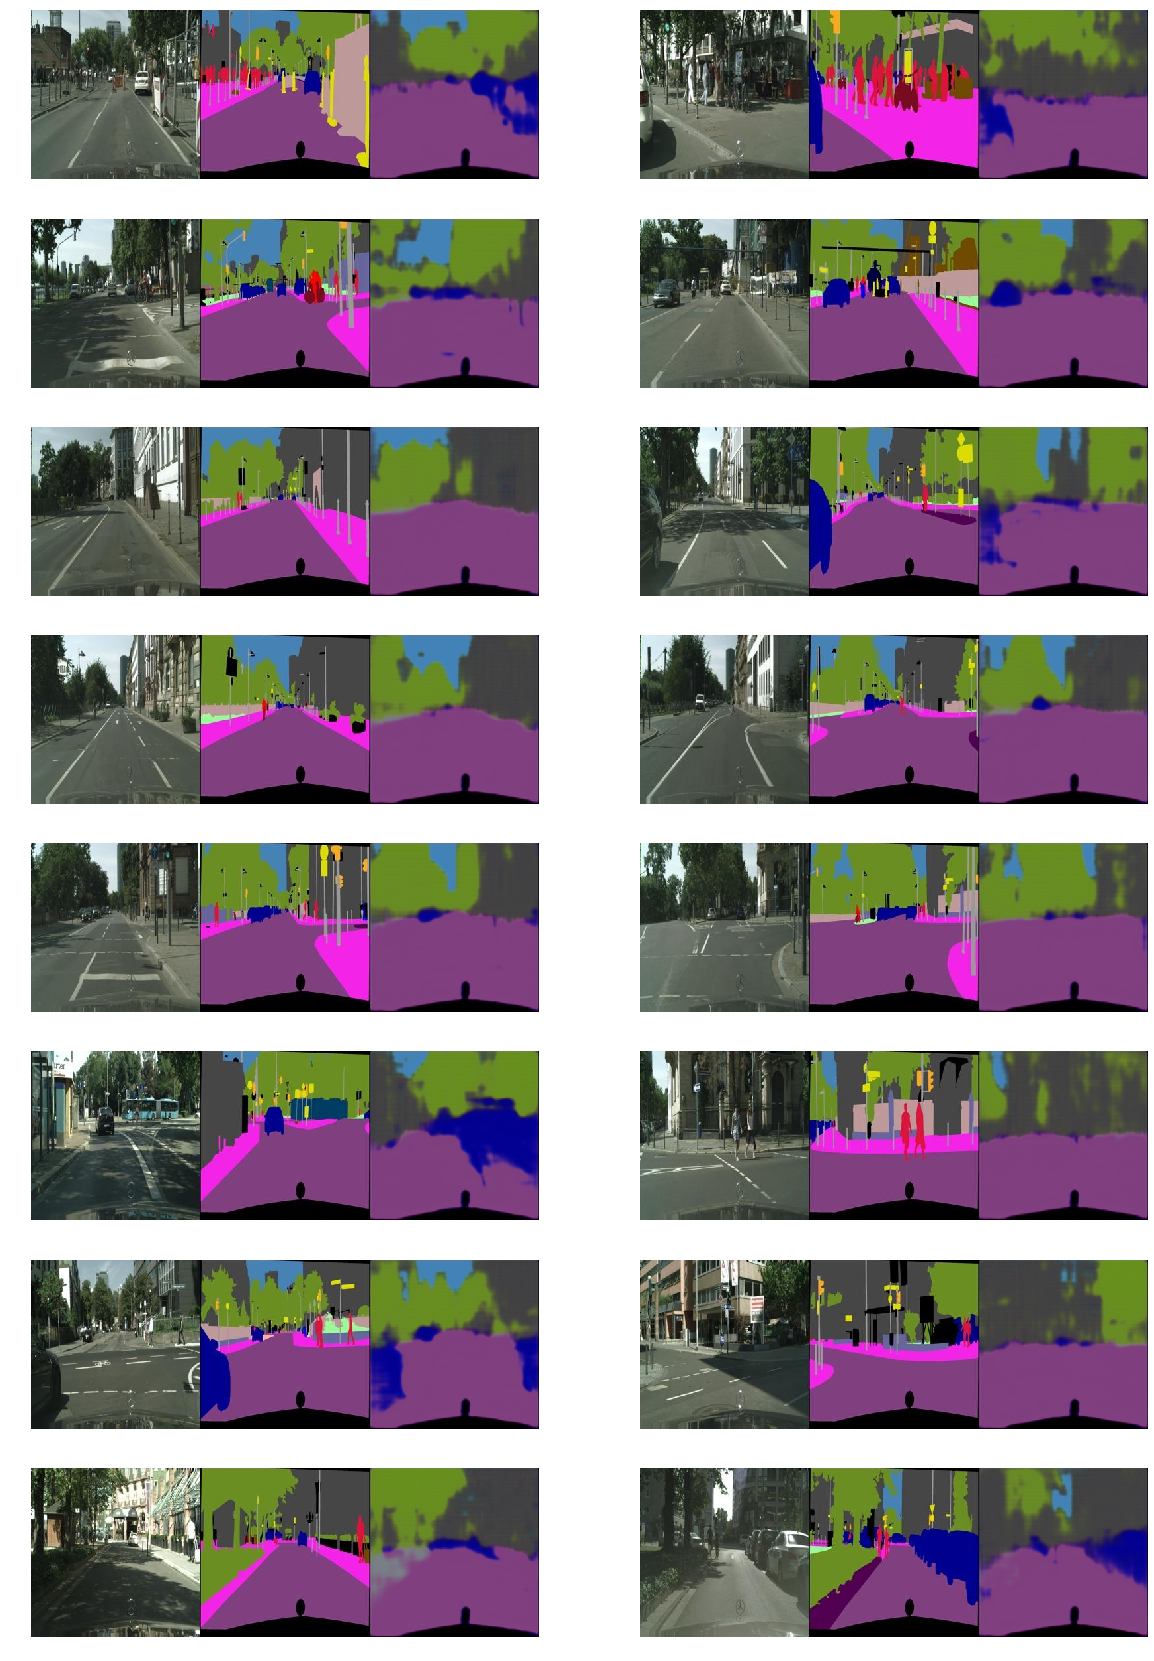

In [37]:
plt.figure(figsize=(20,30))
for i in range(16):
    plt.subplot(8,2,i+1)
    plt.imshow(np.concatenate((xtest[i], ytest[i], ytesthat[i]),axis=1))
    #plt.axis('tight')
    plt.axis('off')
    